# 시군구별 소멸위험지수 프로젝트_모델링

목차:

**[I. 데이터 불러오기](#one)**

**[II. 타겟 변수 시각화](#two)**
- [a. folium](#two-a)
- [b. Cartogram](#two-b)

**[III. EDA & FE](#three)**

- [a. 결측치확인](#three-a)
- [b. 타겟변수](#three-b)
- [c. 지표비교](#three-c)
- [d. 파생변수추가](#three-d)

**[IV. 모델링](#four)**
- [a. K-fold](#four-a)
- [b. GradientBoosting](#four-b)
- [c. RandomForest](#four-c)
- [d. Xgboost](#four-d)
- [e. 앙상블](#four-e)

**[V. 결과](#five)**

## IV. 모델링  <a id="four"></a>

In [1]:
#라이브러리 설치 - 해당 라이브러리가 없다면 아래 코드를 이용해서 설치해주시기 바랍니다.

#!pip install xgboost
#!pip install lightgbm
#!pip install eli5

>버전 정보 python 3.7
>
>pandas:  1.1.2
>
>matplotlib:  3.3.2
>
>seaborn:  0.11.0
>
>folium:  0.11.0
>
>plotly:  4.10.0
>
>sklearn:  0.23.2
>
>patsy:  0.5.1
>
>statsmodels:  0.12.0
>
>xgboost:  1.2.0
>
>lightgbm:  3.0.0
>
>eli5:  0.10.1

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, precision_score, recall_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight
from sklearn.ensemble import VotingClassifier
from scipy.stats import randint as sp_randint
import xgboost as xgb
import eli5 
from eli5.sklearn import PermutationImportance

In [2]:
train = pd.read_csv('모델링_train.csv',encoding='cp949')
test = pd.read_csv('모델링_test.csv', encoding='cp949')

In [3]:
dat1 = train.set_index('Unnamed: 0')
test_x1 = test.set_index('Unnamed: 0')

In [4]:
dat1.head()

,sido,sigun_nm,sigun_code,병원,보건소,상급종합병원,약국,요양병원,의원,종합병원,...,부동산업_종사자수,전문과학기술서비스업_사업체수,전문과학기술서비스업_종사자수,target,등급,평균연령x인구증가율,의료복지기관,가구수당x합계출산율,가구수당_평균연령,녹지지역비율x토지거래면적
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
강원도강릉시,강원도,강릉시,42150,5,1,0,81,4,103,4,...,1196,277,1677,1.423144,b,-22.36,194,108137.888,0.049069,8009.9701
강원도고성군,강원도,고성군,42820,0,1,0,13,0,8,0,...,33,20,94,1.143675,b,-39.10,22,15727.952,0.369686,4793.3755
강원도동해시,강원도,동해시,42170,2,1,0,41,3,50,1,...,560,65,378,1.377623,b,-29.24,97,48261.440,0.119391,2261.6460
강원도삼척시,강원도,삼척시,42230,1,1,0,29,1,26,1,...,326,59,462,1.191157,b,-84.92,58,37995.797,0.151354,7782.4944
강원도속초시,강원도,속초시,42210,1,1,0,43,2,58,2,...,694,81,477,1.438448,b,-11.18,105,49043.944,0.130287,739.1310


In [5]:
test_x1.head()

,sido,sigun_nm,sigun_code,병원,보건소,상급종합병원,약국,요양병원,의원,종합병원,...,부동산업_종사자수,전문과학기술서비스업_사업체수,전문과학기술서비스업_종사자수,target,등급,평균연령x인구증가율,의료복지기관,가구수당x합계출산율,가구수당_평균연령,녹지지역비율x토지거래면적
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
강원도강릉시,강원도,강릉시,42150,3,1,0,89,4,113,4,...,1139,286,2040,1.333658,b,-12.818,210,91743.512,0.048371,8270.9707
강원도고성군,강원도,고성군,42820,0,1,0,13,0,7,0,...,43,25,131,0.947702,a,-271.504,21,12358.632,0.392189,7214.2704
강원도동해시,강원도,동해시,42170,2,1,0,38,3,51,1,...,478,72,378,1.202411,b,-71.928,95,39848.368,0.122119,1434.4052
강원도삼척시,강원도,삼척시,42230,1,1,0,27,1,26,1,...,292,73,716,1.210148,b,-14.656,56,35386.992,0.154146,7937.1764
강원도속초시,강원도,속초시,42210,0,1,0,41,2,64,2,...,726,82,462,1.304214,b,-27.714,108,35013.791,0.131622,936.6500


In [6]:
target = train['등급']
LB = LabelEncoder() 
target = LB.fit_transform(target)
test_target = LB.fit_transform(test['등급'])
print(LB.classes_)

['a' 'b' 'c' 'd']


In [7]:
#모델링 하기위해 불필요 변수들 제거
dat1.drop(['sido','sigun_nm','sigun_code','target','등급'],axis=1, inplace=True)
test_x1.drop(['sido','sigun_nm','sigun_code','target','등급'],axis =1 , inplace = True)

In [8]:
print(len(dat1.columns),len(test_x1.columns))

96 96


In [9]:
#from sklearn.model_selection import train_test_split
#X_tr, X_vld, y_tr, y_vld = train_test_split(dat1, target, test_size = 0.3, random_state = 2019)

> train_test_split은 과적합에 취약한 약점을 가질수 있다. 데이터가 크지 않을때 train vaild를 7:3 으로 나누는것은 알고리즘의 예측 성능을 판단하는데 적절하지 않을수도있음 그래서 교차검증을 실행

### a.K-fold <a id="four-a"></a>

> 데이터의 수가 적은 경우에는 이 데이터 중의 일부인 검증 데이터의 수도 적기 때문에 검증 성능의 신뢰도가 떨어진다. 그렇다고 검증 데이터의 수를 증가시키면 학습용 데이터의 수가 적어지므로 정상적인 학습이 되지 않는다. 이러한 딜레마를 해결하기 위한 검증 방법이 K-폴드(K-fold) 교차검증 방법

> K 겹 교차 검증(Cross validation) 모든 데이터가 최소 한 번은 테스트셋으로 쓰이도록 하는것
> 1. Unseen 데이터에 대한 성능을 예측하기 위해
>
> 2. 더 좋은 모델을 선택하기 위해 (혹은 Hyperparameter Tuning)

In [10]:
kfold = StratifiedKFold(n_splits=10)

> 그중에서 Stratified K 폴드는 불균형한 분포도를 가진 레이블 데이터 집합을 위한 K-폴드 방식
일반적으로 분류에서의 교차검증은 K 폴드가 아니라 Stratified K 폴드로 분할해야해

In [11]:
# 각 분류모델들을 clf에 붙여넣음
random_state = 1
clf = []

clf.append(XGBClassifier(random_state = random_state))
clf.append(KNeighborsClassifier())
clf.append(RandomForestClassifier(random_state=random_state))
clf.append(GradientBoostingClassifier(random_state=random_state))
clf.append(DecisionTreeClassifier(random_state=random_state))
clf.append(LogisticRegression(random_state = random_state))
clf.append(SVC(random_state=random_state))

In [12]:
# 각 모델의 f1_weighted score의 결과를 clf_result에 저장
clf_results = []
for classifier in clf :
    clf_results.append(cross_val_score(classifier, dat1, y = target, scoring = "f1_weighted", cv = kfold, n_jobs=4))

In [13]:
# 각 모델의 f1_weighted score의 평균과 표준편차를 저장
clf_means = []
clf_std = []
for clf_result in clf_results:
    clf_means.append(clf_result.mean())
    clf_std.append(clf_result.std())

In [14]:
# 각 모델의 f1 결과값들을 데이터프레임화
clf_re = pd.DataFrame({"CrossValMeans":clf_means,"CrossValerrors": clf_std},
                     index=['XGB','KNeighbors','RF','GBC','DT','Logist','SVC'])
clf_re

,CrossValMeans,CrossValerrors
XGB,0.882298,0.036967
KNeighbors,0.522065,0.078578
RF,0.887933,0.029035
GBC,0.885359,0.034012
DT,0.813907,0.047284
Logist,0.282414,0.067128
SVC,0.359241,0.089164


> 모든 변수를 포함한 데이터셋을 학습시켰을때의 결과

<BarContainer object of 7 artists>

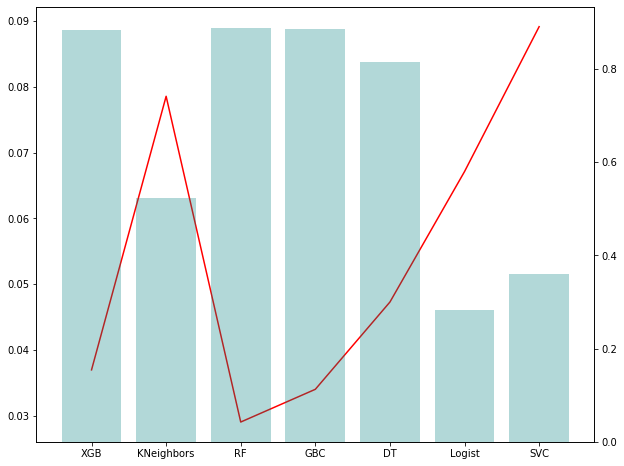

In [15]:
#모델의 결과를 그래프화
fig, ax1 = plt.subplots(figsize = (10,8))
ax1.plot(clf_re['CrossValerrors'], color = 'r')

ax2 = ax1.twinx()
ax2.bar(clf_re.index, clf_re['CrossValMeans'], alpha = 0.3,color = 'teal')

>데이터 세트를 10개의 그룹으로 분할한 다음에 10개의 모델에 대해서 기본 모델을 구축한 뒤 RandomizedSearchCV를 통해서 변수들을 최적화 시켜줍니다. kfold 확인 결과 3개의 모델을 이용해서 앙상블 하려고 합니다

### b.GradientBoosting <a id="four-b"></a>

>부스팅은 머신러닝 앙상블 기법 중 하나로 sequential한 weak learner들을 여러개 결합하여 예측 혹은 분류 성능을 높이는 알고리즘

>- Sequential한 weak learner들을 residual을 줄이는 방향으로 결합하여 object function과의 loss를 줄여나가는 아이디어. 여기서 정의되는 residual이 negative gradient와 같은 의미를 지니게 되므로 gradient 부스팅이라는 이름이 붙었다

In [16]:
#gbc 파라미터 튜닝
parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,1000)
    }

model_gb= GradientBoostingClassifier(random_state=16)

In [17]:
# RandomizedSearchCV를 통해서 파라미터 최적화 여기서 stratifed kfold 사용
# 파라미터 튜닝 후 학습 결과 105분이 소요됨
# 최적화된 파라미터들 
gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = kfold, 
                               verbose=2, random_state=16,n_jobs = -1, scoring='f1_weighted')
gb_random.fit(dat1,target)

gb_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 24.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 100.5min finished


{'subsample': 1.0,
 'n_estimators': 773,
 'min_samples_split': 0.1,
 'min_samples_leaf': 15,
 'max_features': 'log2',
 'max_depth': 30,
 'loss': 'deviance',
 'learning_rate': 0.2,
 'criterion': 'friedman_mse'}

In [18]:
# 최적화된 파라미터를 가지고 GBC모델을 만듬
model_gbc = GradientBoostingClassifier(**gb_random.best_params_)
model_gbc.fit(dat1, target)

GradientBoostingClassifier(learning_rate=0.2, max_depth=30, max_features='log2',
                           min_samples_leaf=15, min_samples_split=0.1,
                           n_estimators=773)

In [19]:
# 모델에서 test를 예측하고 f1_score점수화
Predicted_gbc = model_gbc.predict(test_x1)
gbc_f1 = cross_val_score(model_gbc, dat1, target, cv=kfold, scoring='f1_weighted').mean()

In [20]:
#4가지 f1_score 비교 함수
def four_f1(model_f1,model):
    print("F1 Cross_validate",model_f1)
    print("F1 Macro:",f1_score(test_target, model, average='macro'))
    print("F1 Micro:",f1_score(test_target, model, average='micro'))  
    print("F1 Weighted:",f1_score(test_target, model, average='weighted'))
    print("\nMatrix of confusion")
    return confusion_matrix(test_target, model)

In [21]:
#각각의 f1_score점수 
four_f1(gbc_f1,Predicted_gbc)

F1 Cross_validate 0.8977127168887284
F1 Macro: 0.8927282395024331
F1 Micro: 0.8947368421052632
F1 Weighted: 0.8957137938462217

Matrix of confusion


array([[65,  9,  0,  0],
       [ 1, 44,  4,  0],
       [ 0,  2, 55,  7],
       [ 0,  0,  1, 40]], dtype=int64)

In [22]:
# confusion_matrix 시각화 함수
def cnf_matrix_model(model):
    cnf_matrix_gbc = confusion_matrix(test_target, model)
    g = sns.heatmap(pd.DataFrame(cnf_matrix_gbc), annot=True, cmap="BuGn", fmt='g')
    buttom , top = g.get_ylim()
    g.set_ylim(buttom+0.5, top-0.5)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    return g

<AxesSubplot:xlabel='Predicted Label', ylabel='Actual Label'>

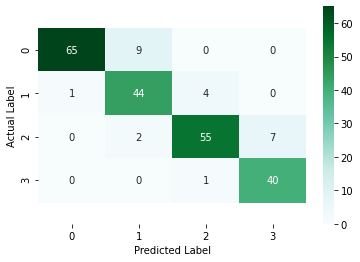

In [23]:
cnf_matrix_model(Predicted_gbc)

### gbc voting

In [24]:
#다중 분류기들을 Voting하는 방법을 사용하기 위해 GBC 모델의 random_state(난수값)을 변경해가면서 10개의 GBC 분류기를 만들어냄
#파라미터는 위에서 정의해준 최적 파라미터 사용 
ets_gbc = []    
for i in range(10):
    gbc = GradientBoostingClassifier(random_state=217+i,**gb_random.best_params_)
    ets_gbc.append(('gbc{}'.format(i), gbc))   

In [25]:
# target 불균형에 대해 class_weigt 라이브러리 사용
# 클래스 불균형 문제를 해소하기 위해 compute_sample_weight 사용

y_train_weights = class_weight.compute_sample_weight('balanced', target, indices=None)

In [26]:
# VotingClassifier 정의 
# 위에서 정의해준 10개의 GBC 분류기를 사용
# 앙상블의 소프트 보팅
vc2 = VotingClassifier(ets_gbc, voting='soft')    
_ = vc2.fit(dat1, target,sample_weight=y_train_weights)    

In [27]:
gbc_clf_final = vc2.estimators_[0]

In [28]:
# 단일 모델, soft voting, hard voting 3가지 방법에 대한 점수
gbc_global_score = f1_score(test_target, gbc_clf_final.predict(test_x1), average='weighted')
vc2.voting = 'hard'
gbc_global_score_hard = f1_score(test_target, vc2.predict(test_x1), average='weighted')
vc2.voting = 'soft'
gbc_global_score_soft = f1_score(test_target, vc2.predict(test_x1),average='weighted')

In [29]:
# Soft Voting 방법이 가장 높은 점수를 보임 
print('Validation score of a single XGB Classifier: {:.4f}'.format(gbc_global_score))
print('Validation score of a VotingClassifier on 3 XGB with hard voting strategy: {:.4f}'.format(gbc_global_score_hard))
print('Validation score of a VotingClassifier on 3 XGB with soft voting strategy: {:.4f}'.format(gbc_global_score_soft))

Validation score of a single XGB Classifier: 0.9042
Validation score of a VotingClassifier on 3 XGB with hard voting strategy: 0.9042
Validation score of a VotingClassifier on 3 XGB with soft voting strategy: 0.9042


> soft 보팅의 경우 f1_score 0.9042

f1  0.9041742397858935
              precision    recall  f1-score   support

           0       0.99      0.89      0.94        74
           1       0.81      0.90      0.85        49
           2       0.93      0.86      0.89        64
           3       0.85      1.00      0.92        41

    accuracy                           0.90       228
   macro avg       0.90      0.91      0.90       228
weighted avg       0.91      0.90      0.90       228



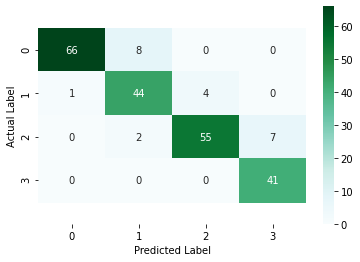

In [30]:
cnf_matrix_vgbc = confusion_matrix(test_target, vc2.predict(test_x1))
g = sns.heatmap(pd.DataFrame(cnf_matrix_vgbc), annot=True, cmap="BuGn", fmt='g')
buttom , top = g.get_ylim()
g.set_ylim(buttom+0.5, top-0.5)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print('f1 ',f1_score(y_true=test_target, y_pred=vc2.predict(test_x1), average='weighted'))
print(classification_report(test_target, vc2.predict(test_x1)))

### c.RandomForest <a id="four-c"></a>

In [31]:
# RandomForest 파라미터 튜닝
parametros_rf = {"max_depth": [3, 5,10,20,30,40,None],
            'max_features': ['auto', 'sqrt'],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
             'n_estimators': [10,100,200,500,800,1000],
              "bootstrap": [True, False]
             }
model_rf= RandomForestClassifier(random_state=16)

In [32]:
# 파라미터 최적화 cv = kfold(stratifed kfold 이용)
# 파라미터 최적화 시간 7분 
# 최적의 파라미터들
rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = parametros_rf, n_iter = 100, cv = kfold, 
                               verbose=2, random_state=16,n_jobs = -1, scoring='f1_weighted')
rf_random.fit(dat1,target)
rf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  6.6min finished


{'bootstrap': False,
 'max_depth': 10,
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [33]:
# 최적화된 파라미터를 가지고 RF모델 만듬
model_rf = RandomForestClassifier(**rf_random.best_params_)
model_rf.fit(dat1,target)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features=7,
                       min_samples_split=3)

In [34]:
# RF모델로 test 데이터 예측과 점수
Predicted_rf = model_rf.predict(test_x1)
rf_f1 = cross_val_score(model_rf, dat1,target, cv=kfold, scoring='f1_weighted').mean()

In [35]:
# RF 모델의 f1 score
four_f1(rf_f1,Predicted_rf)

F1 Cross_validate 0.8880985857693998
F1 Macro: 0.884410087053297
F1 Micro: 0.8859649122807017
F1 Weighted: 0.8874800550123053

Matrix of confusion


array([[64, 10,  0,  0],
       [ 0, 42,  7,  0],
       [ 0,  2, 57,  5],
       [ 0,  0,  2, 39]], dtype=int64)

<AxesSubplot:xlabel='Predicted Label', ylabel='Actual Label'>

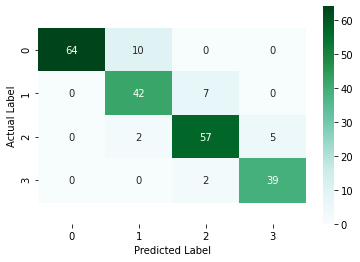

In [36]:
# confusion_matrix 시각화
cnf_matrix_model(Predicted_rf)

### rf voting

In [37]:
# 다중 분류기들을 Voting하는 방법을 사용하기 위해 RF 모델의 random_state(난수값)을 변경해가면서 10개의 RF 분류기를 만들어냄
# 파라미터는 위에서 정의해준 최적 파라미터 사용 

rf_ets = []    
for i in range(10):
    rf = RandomForestClassifier(random_state=217+i,**rf_random.best_params_)
    rf_ets.append(('rf{}'.format(i), rf))   

In [38]:
# 위에서 정의해준 10개의 rf분류기를 사용
# 앙상블의 소프트 보팅
vc3 = VotingClassifier(rf_ets, voting='soft')    
_ = vc3.fit(dat1,target,sample_weight=y_train_weights)    

In [39]:
rf_clf_final = vc3.estimators_[0]

In [40]:
# 단일 모델, soft voting, hard voting 3가지 방법에 대한 점수
rf_global_score = f1_score(test_target, rf_clf_final.predict(test_x1), average='weighted')
vc3.voting = 'hard'
rf_global_score_hard = f1_score(test_target, vc3.predict(test_x1),average='weighted')
vc3.voting = 'soft'
rf_global_score_soft = f1_score(test_target, vc3.predict(test_x1), average='weighted')

In [41]:
# soft Voting 방법이 가장 높은 점수를 보임 
print('Validation score of a singl rf Classifier: {:.4f}'.format(rf_global_score))
print('Validation score of a VotingClassifier on 3 rf with soft voting strategy: {:.4f}'.format(rf_global_score_soft))
print('Validation score of a VotingClassifier on 3 rf with hard voting strategy: {:.4f}'.format(rf_global_score_hard))

Validation score of a singl rf Classifier: 0.8829
Validation score of a VotingClassifier on 3 rf with soft voting strategy: 0.8828
Validation score of a VotingClassifier on 3 rf with hard voting strategy: 0.8828


f1  0.8828186319722502
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        74
           1       0.77      0.84      0.80        49
           2       0.86      0.89      0.88        64
           3       0.89      0.95      0.92        41

    accuracy                           0.88       228
   macro avg       0.88      0.89      0.88       228
weighted avg       0.89      0.88      0.88       228



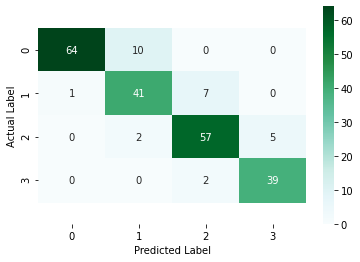

In [42]:
cnf_matrix_vrf = confusion_matrix(test_target, vc3.predict(test_x1))
g = sns.heatmap(pd.DataFrame(cnf_matrix_vrf), annot=True, cmap="BuGn", fmt='g')
buttom , top = g.get_ylim()
g.set_ylim(buttom+0.5, top-0.5)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print('f1 ',f1_score(y_true=test_target, y_pred=vc3.predict(test_x1), average='weighted'))
print(classification_report(test_target, vc3.predict(test_x1)))

soft voting의 경우 0.8828186319722502

### d.xgboost <a id="four-d"></a>

> - GBM은 residaul을 줄이는 방향으로 weak learner를 결합해 강력한 성능을 자랑하지만, 해당 train data에 residual을 계속 줄이니까 overfitting 되기 쉽다는 문제점이 있다. 이를 해결하기 위해 XGBoost는 GBM에 regularization term을 추가한 알고리즘이다. 또한 다양한 loss function을 지원해 task에 따른 유연한 튜닝이 가능하다는 장점이 있다

> XGBoost = GBM + Regularization+ 다양한 Loss function 지원

[02:47:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { cv } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


f1  0.9003906654932211
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        74
           1       0.81      0.94      0.87        49
           2       0.88      0.91      0.89        64
           3       0.90      0.88      0.89        41

    accuracy                           0.90       228
   macro avg       0.90      0.90      0.90       228
weighted avg       0.91      0.90      0.90       228



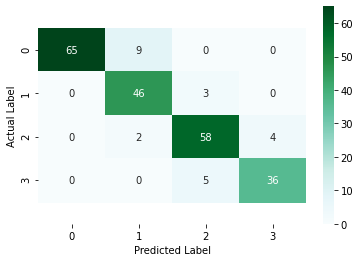

In [43]:
#xgboost 모델 생성 후 학습
#모델 생성
model = xgb.XGBClassifier(n_estimators = 5000, max_depth = 30, cv= kfold,learning_rate = 0.01,random_state = 16)
#모델 학습
model.fit(dat1, target) 
#예측 분류
y_pred = model.predict(test_x1)

#오분류표 코드 
cnf_matrix = confusion_matrix(test_target, y_pred)
g = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuGn", fmt='g')
buttom , top = g.get_ylim()
g.set_ylim(buttom+0.5, top-0.5)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

#f1 score와 오분류표 보여줌
print('f1 ',f1_score(y_true=test_target, y_pred=y_pred, average='weighted')) #불균현 문제를 위하 가중치 weighted 
print(classification_report(test_target, y_pred))

> accuracy의 경우 데이터가 균형있을때 효과적이고 f1_score의 경우 데이터가 불균형일때 효과적
지방 소멸위험의 경우 소멸위험이적은 D등급이 36개로 불균형으로 f1_score를 채택한다

> 실제 a등급(0)을 a등급으로 제대로 예측한 데이터 65개 
>
> f1_score 90%이며  confusion_matrix확인결과 데이터가 잘 분류된것을 확인할수있음

In [44]:
#변수 중요도 코드
def plot_feature_importance(model, X_train, figsize=(12, 6)):
    sns.set_style('darkgrid')
    
    # Plot feature importance
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=figsize)
    plt.rc("font",family="Malgun Gothic")
    plt.rc("axes",unicode_minus=False)
    
    plt.barh(pos, feature_importance[sorted_idx], align='center',color = 'teal' )
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

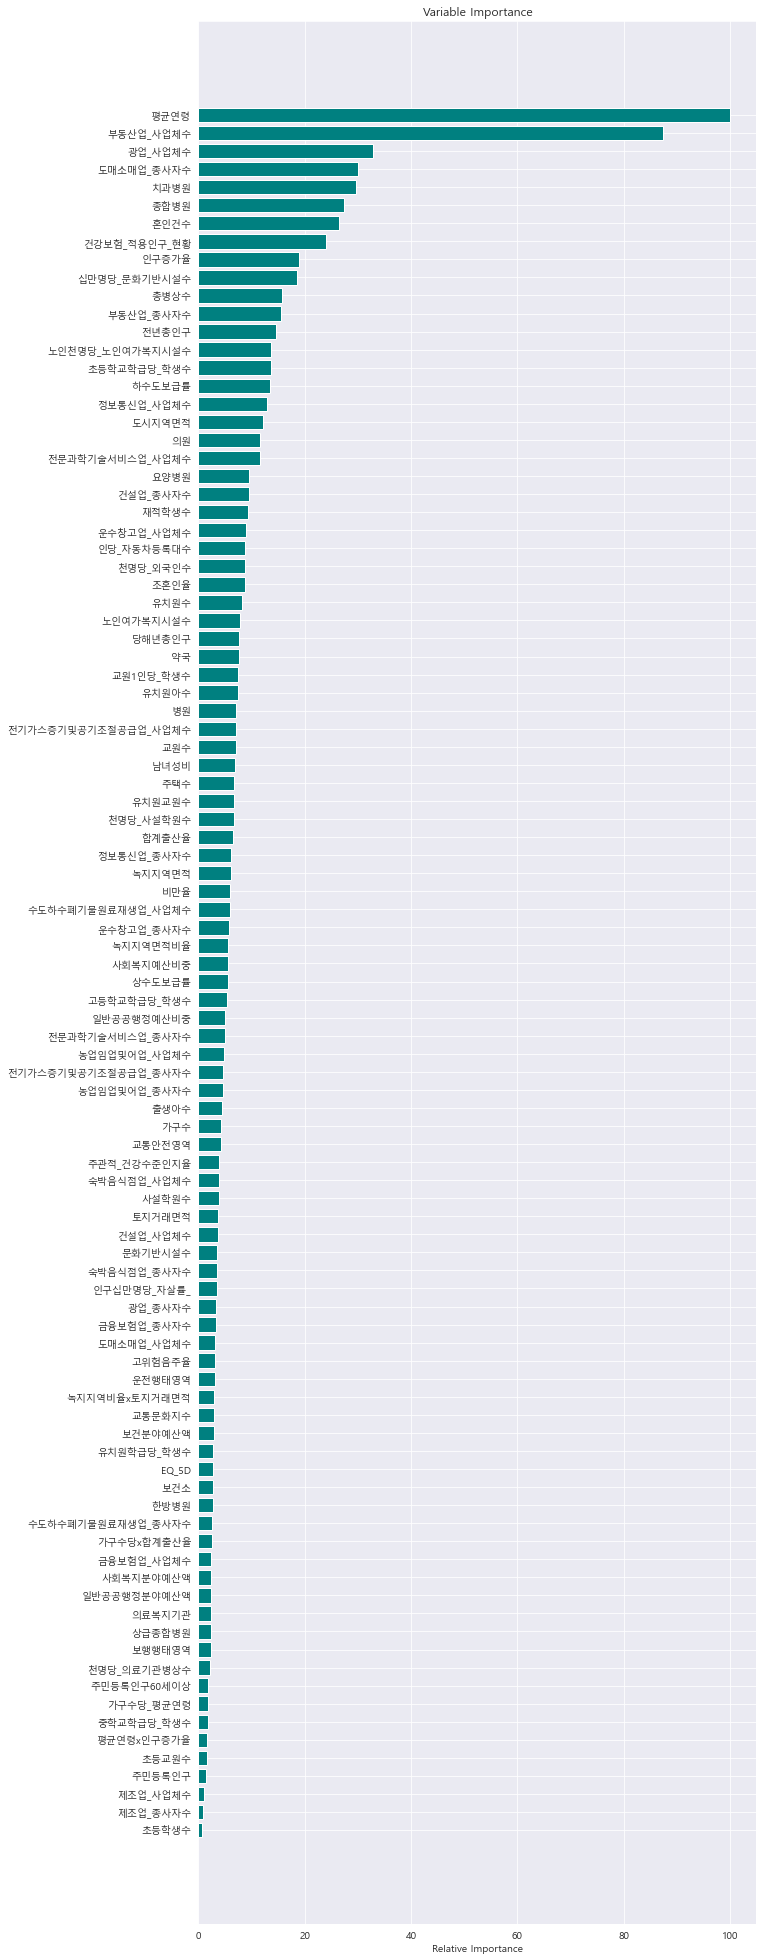

In [45]:
# 변수 중요도 확인 
plot_feature_importance(model, dat1, (10, 35))

In [46]:
# Permutation Importance 확인 
perm = PermutationImportance(model, scoring = "f1_weighted",random_state = 42).fit(dat1, target)
eli5.show_weights(perm, top = 100, feature_names = dat1.columns.tolist())

Weight,Feature
0.3049 ± 0.0232,평균연령
0.0459 ± 0.0078,십만명당_문화기반시설수
0.0386 ± 0.0092,인구증가율
0.0205 ± 0.0018,노인천명당_노인여가복지시설수
0.0023 ± 0.0023,혼인건수
0.0015 ± 0.0000,광업_사업체수
0.0003 ± 0.0012,조혼인율
0 ± 0.0000,교통안전영역
0 ± 0.0000,주민등록인구60세이상
0 ± 0.0000,교원1인당_학생수


In [47]:
#트리모델 시각화 색하고 모형결정 
node_params = {'shape': 'box',
              'style':'filled, rounded',
              'fillcolor': 'LightBlue'}
leaf_params = {'shape':'box',
              'style':'filled',
              'fillcolor':'GreenYellow'}

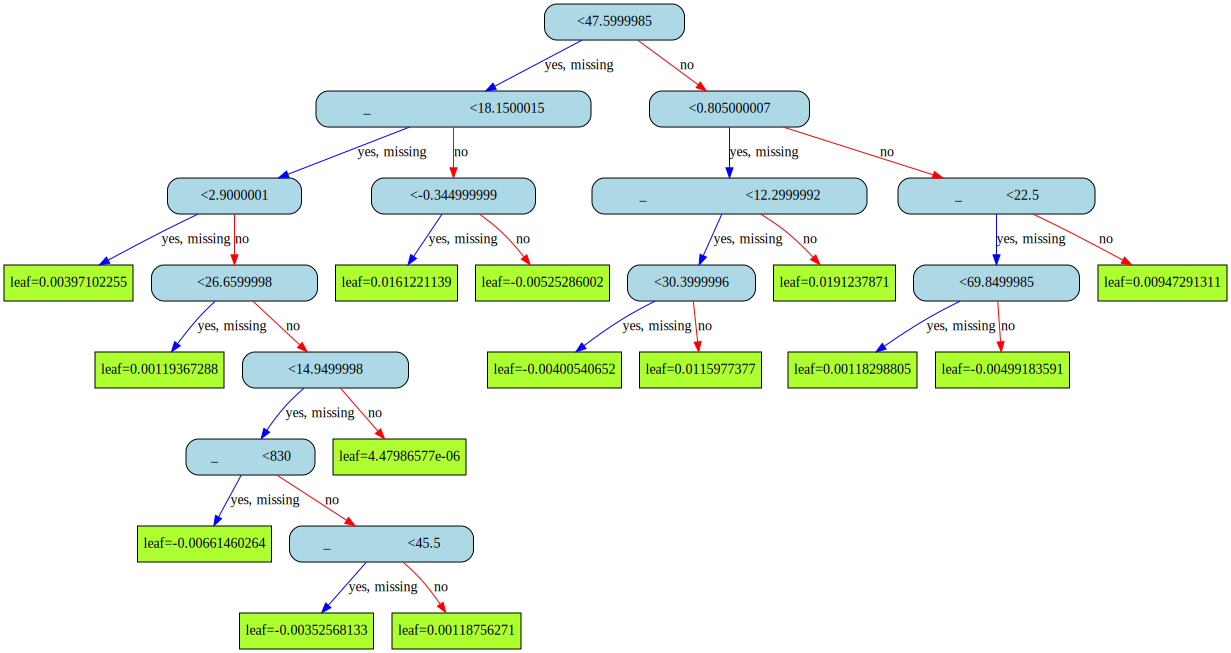

In [48]:
# 트리모델 시각화
xgb.to_graphviz(model, num_trees=4, size='5,10',
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

### 파라미터 튜닝

> 파라미터 튜닝시 RandomizedSearchCV를 이용하였음

In [49]:
# 최적의 파라미터 검색을 위한 파라미터 정의

xgb_clf = xgb.XGBClassifier(eval_metric = ["merror", "map", "auc"],silent=0 ,objective = "multi:softmax",random_state=16)
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 1, 2],
               "max_depth": range(1,50),
               "colsample_bytree": [0.3, 0.8, 1.0],
               "colsample_bylevel" : [0.8,0.85,0.9],
               "subsample": [0.8,0.85,0.88,0.9],
               'num_class': [1,4,8],
               "reg_lambda": [0, 0.5, 1],
               "eta" : [0.1,0.01],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": range(500,2000)}

>xgb.XGBClassifier(eval_metric = ["merror", "map", "auc"]
>
>  merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases) 
>
> map: Mean Average Precision 
>
> auc: Area under the curve

In [50]:
# RandomizedSearchCV를  사용하여 최적의 파라미터 검색 
# stratifed kfold 이용
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = 'f1_weighted',
                             cv = kfold, verbose = 3, random_state = 16)
model_xgboost = xgb_rscv.fit(dat1, target)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.85, reg_lambda=0, num_class=4, n_estimators=1663, min_child_weight=7, max_depth=30, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.85 
[02:49:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  subsample=0.85, reg_lambda=0, num_class=4, n_estimators=1663, min_child_weight=7, max_depth=30, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.85, score=0.850, total=   5.1s
[CV] subsample=0.85, reg_lambda=0, num_class=4, n_estimators=1663, min_child_weight=7, max_depth=30, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.85 
[02:49:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=0, num_class=4, n_estimators=1663, min_child_weight=7, max_depth=30, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.85, score=0.809, total=   5.3s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.2s remaining:    0.0s


[CV]  subsample=0.85, reg_lambda=0, num_class=4, n_estimators=1663, min_child_weight=7, max_depth=30, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.85, score=0.807, total=   5.0s
[CV] subsample=0.85, reg_lambda=0, num_class=4, n_estimators=1663, min_child_weight=7, max_depth=30, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.85 
[02:49:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=0, num_class=4, n_estimators=1663, min_child_weight=7, max_depth=30, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.85, score=0.925, total=   5.4s

[CV]  subsample=0.88, reg_lambda=0, num_class=8, n_estimators=597, min_child_weight=3, max_depth=28, learning_rate=0.1, gamma=2, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.9, score=0.897, total=   5.3s
[CV] subsample=0.88, reg_lambda=0, num_class=8, n_estimators=597, min_child_weight=3, max_depth=28, learning_rate=0.1, gamma=2, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.9 
[02:50:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.88, reg_lambda=0, num_class=8, n_estimators=597, min_child_weight=3, max_depth=28, learning_rate=0.1, gamma=2, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.9, score=0.927, total=   5.4s
[CV] subsample

[CV]  subsample=0.85, reg_lambda=1, num_class=8, n_estimators=994, min_child_weight=5, max_depth=20, learning_rate=0.1, gamma=0.01, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.883, total=   2.8s
[CV] subsample=0.85, reg_lambda=1, num_class=8, n_estimators=994, min_child_weight=5, max_depth=20, learning_rate=0.1, gamma=0.01, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8 
[02:51:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=1, num_class=8, n_estimators=994, min_child_weight=5, max_depth=20, learning_rate=0.1, gamma=0.01, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.881, total=   2.7s
[C

[CV]  subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=728, min_child_weight=3, max_depth=30, learning_rate=0.01, gamma=1, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.898, total=   5.7s
[CV] subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=728, min_child_weight=3, max_depth=30, learning_rate=0.01, gamma=1, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8 
[02:51:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=728, min_child_weight=3, max_depth=30, learning_rate=0.01, gamma=1, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.867, total=   5.9s
[CV] 

[CV]  subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=1419, min_child_weight=1, max_depth=29, learning_rate=0.001, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.897, total=  16.2s
[CV] subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=1419, min_child_weight=1, max_depth=29, learning_rate=0.001, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8 
[02:54:12] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=1419, min_child_weight=1, max_depth=29, learning_rate=0.001, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.941, tota

[CV]  subsample=0.9, reg_lambda=0, num_class=8, n_estimators=916, min_child_weight=5, max_depth=12, learning_rate=0.001, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.9, score=0.867, total=   7.3s
[CV] subsample=0.9, reg_lambda=0, num_class=8, n_estimators=916, min_child_weight=5, max_depth=12, learning_rate=0.001, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.9 
[02:55:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, reg_lambda=0, num_class=8, n_estimators=916, min_child_weight=5, max_depth=12, learning_rate=0.001, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.9, score=0.844, total=   7.1s
[CV] sub

[CV]  subsample=0.8, reg_lambda=1, num_class=4, n_estimators=524, min_child_weight=7, max_depth=25, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.837, total=   1.9s
[CV] subsample=0.8, reg_lambda=1, num_class=4, n_estimators=524, min_child_weight=7, max_depth=25, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8 
[02:56:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.8, reg_lambda=1, num_class=4, n_estimators=524, min_child_weight=7, max_depth=25, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.896, total=   1.9s
[CV] sub

[CV]  subsample=0.85, reg_lambda=1, num_class=8, n_estimators=559, min_child_weight=7, max_depth=24, learning_rate=0.001, gamma=0.01, eta=0.1, colsample_bytree=0.3, colsample_bylevel=0.85, score=0.808, total=   2.7s
[CV] subsample=0.9, reg_lambda=1, num_class=4, n_estimators=626, min_child_weight=7, max_depth=19, learning_rate=0.001, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.9 
[02:56:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, reg_lambda=1, num_class=4, n_estimators=626, min_child_weight=7, max_depth=19, learning_rate=0.001, gamma=0.01, eta=0.1, colsample_bytree=1.0, colsample_bylevel=0.9, score=0.846, total=   6.3s


[CV]  subsample=0.8, reg_lambda=1, num_class=8, n_estimators=1021, min_child_weight=5, max_depth=48, learning_rate=0.01, gamma=0.01, eta=0.01, colsample_bytree=0.8, colsample_bylevel=0.85, score=0.850, total=   6.2s
[CV] subsample=0.8, reg_lambda=1, num_class=8, n_estimators=1021, min_child_weight=5, max_depth=48, learning_rate=0.01, gamma=0.01, eta=0.01, colsample_bytree=0.8, colsample_bylevel=0.85 
[02:58:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.8, reg_lambda=1, num_class=8, n_estimators=1021, min_child_weight=5, max_depth=48, learning_rate=0.01, gamma=0.01, eta=0.01, colsample_bytree=0.8, colsample_bylevel=0.85, score=0.841, total=   6

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.9min finished


> RandomizedSearchCV를 통해서 모델에 최적화된 파라미터를 찾음

In [51]:
# 최적의 파라미터 목록

best_param = model_xgboost.best_params_
best_param

{'subsample': 0.85,
 'reg_lambda': 0.5,
 'num_class': 1,
 'n_estimators': 1419,
 'min_child_weight': 1,
 'max_depth': 29,
 'learning_rate': 0.001,
 'gamma': 0.01,
 'eta': 0.1,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.8}

> xgboost 최적화된 파라미터

In [52]:
model_xgb = xgb.XGBClassifier(**best_param)
model_xgb.fit(dat1, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0.01,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=29,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1419, n_jobs=0, num_class=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.5, scale_pos_weight=None, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
Predicted_xgb= model_xgb.predict(test_x1)
test_xgb_f1 = cross_val_score(model_xgb, dat1, target, cv=kfold, scoring='f1_weighted').mean()

In [54]:
four_f1(test_xgb_f1,Predicted_xgb)

F1 Cross_validate 0.8870841092994164
F1 Macro: 0.8863759657543425
F1 Micro: 0.8903508771929824
F1 Weighted: 0.8917989593415837

Matrix of confusion


array([[66,  8,  0,  0],
       [ 0, 44,  5,  0],
       [ 0,  2, 57,  5],
       [ 0,  0,  5, 36]], dtype=int64)

> 첫 파라미터 조절 후 f1_score 89.1% 

In [55]:
xgb_clf = xgb.XGBClassifier(eval_metric = ["merror", "map", "auc"],silent=0 ,objective = "multi:softmax",random_state=16)
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 1, 2],
               "max_depth": range(20,40),
               "colsample_bytree": [0.3, 0.8, 1.0],
               "colsample_bylevel" : [0.8,0.85,0.9],
               "subsample": [0.8,0.85,0.88,0.9],
               'num_class': range(1,5),
               "reg_lambda": [0, 0.5, 1],
               "eta" : [0.1,0.01],
               "min_child_weight": range(1,10),
               "n_estimators": range(500,2000)}

> 두번째 파라미터 조정 같은 경우에는 스코어에 영향이 클거같은 n_estimators, max_depth, num_class에 대해 하였음

In [56]:
xgb_rscv1 = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = 'f1_weighted',
                             cv = kfold, verbose = 3, random_state = 16)
model_xgboost1 = xgb_rscv1.fit(dat1, target)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85 
[03:02:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85, score=0.865, total=   9.2s
[CV] subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85 
[03:02:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV]  subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85, score=0.826, total=   9.0s
[CV] subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85 
[03:03:08] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.1s remaining:    0.0s


[CV]  subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85, score=0.823, total=   9.4s
[CV] subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85 
[03:03:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=0, num_class=3, n_estimators=1747, min_child_weight=9, max_depth=39, learning_rate=0.01, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.85, score=0.941, total=   9

[CV]  subsample=0.88, reg_lambda=0, num_class=2, n_estimators=1698, min_child_weight=1, max_depth=25, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.3, colsample_bylevel=0.9, score=0.941, total=   4.6s
[CV] subsample=0.88, reg_lambda=0, num_class=2, n_estimators=1698, min_child_weight=1, max_depth=25, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.3, colsample_bylevel=0.9 
[03:04:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.88, reg_lambda=0, num_class=2, n_estimators=1698, min_child_weight=1, max_depth=25, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.3, colsample_bylevel=0.9, score=0.883, total=   4.7s
[C

[CV]  subsample=0.85, reg_lambda=1, num_class=1, n_estimators=1621, min_child_weight=5, max_depth=33, learning_rate=0.01, gamma=2, eta=0.1, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.882, total=   7.9s
[CV] subsample=0.85, reg_lambda=1, num_class=1, n_estimators=1621, min_child_weight=5, max_depth=33, learning_rate=0.01, gamma=2, eta=0.1, colsample_bytree=0.3, colsample_bylevel=0.8 
[03:05:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=1, num_class=1, n_estimators=1621, min_child_weight=5, max_depth=33, learning_rate=0.01, gamma=2, eta=0.1, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.881, total=   7.2s
[CV] sub

[CV]  subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=1796, min_child_weight=1, max_depth=29, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.898, total=   5.4s
[CV] subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=1796, min_child_weight=1, max_depth=29, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8 
[03:06:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=0.5, num_class=1, n_estimators=1796, min_child_weight=1, max_depth=29, learning_rate=0.1, gamma=0.01, eta=0.1, colsample_bytree=0.8, colsample_bylevel=0.8, score=0.882, total=   5

[CV]  subsample=0.85, reg_lambda=0.5, num_class=2, n_estimators=1189, min_child_weight=1, max_depth=36, learning_rate=0.01, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.882, total=   7.9s
[CV] subsample=0.85, reg_lambda=0.5, num_class=2, n_estimators=1189, min_child_weight=1, max_depth=36, learning_rate=0.01, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8 
[03:08:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.85, reg_lambda=0.5, num_class=2, n_estimators=1189, min_child_weight=1, max_depth=36, learning_rate=0.01, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.897, total=   8.2s

[CV]  subsample=0.9, reg_lambda=0, num_class=3, n_estimators=1562, min_child_weight=5, max_depth=25, learning_rate=0.1, gamma=1, eta=0.01, colsample_bytree=1.0, colsample_bylevel=0.85, score=0.941, total=   9.1s
[CV] subsample=0.9, reg_lambda=0, num_class=3, n_estimators=1562, min_child_weight=5, max_depth=25, learning_rate=0.1, gamma=1, eta=0.01, colsample_bytree=1.0, colsample_bylevel=0.85 
[03:09:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, reg_lambda=0, num_class=3, n_estimators=1562, min_child_weight=5, max_depth=25, learning_rate=0.1, gamma=1, eta=0.01, colsample_bytree=1.0, colsample_bylevel=0.85, score=0.821, total=   8.6s
[CV] sub

[CV]  subsample=0.8, reg_lambda=1, num_class=2, n_estimators=893, min_child_weight=3, max_depth=22, learning_rate=0.1, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.803, total=   4.1s
[CV] subsample=0.8, reg_lambda=1, num_class=2, n_estimators=893, min_child_weight=3, max_depth=22, learning_rate=0.1, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8 
[03:10:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.8, reg_lambda=1, num_class=2, n_estimators=893, min_child_weight=3, max_depth=22, learning_rate=0.1, gamma=2, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.8, score=0.882, total=   4.3s
[CV] subsample

[CV]  subsample=0.85, reg_lambda=1, num_class=4, n_estimators=919, min_child_weight=6, max_depth=22, learning_rate=0.01, gamma=0.01, eta=0.01, colsample_bytree=1.0, colsample_bylevel=0.8, score=0.883, total=   6.0s
[CV] subsample=0.9, reg_lambda=1, num_class=4, n_estimators=969, min_child_weight=9, max_depth=30, learning_rate=0.001, gamma=0.01, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.9 
[03:11:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, reg_lambda=1, num_class=4, n_estimators=969, min_child_weight=9, max_depth=30, learning_rate=0.001, gamma=0.01, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.9, score=0.813, total=   4.8s

[CV]  subsample=0.8, reg_lambda=1, num_class=2, n_estimators=1641, min_child_weight=2, max_depth=35, learning_rate=0.01, gamma=1, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.85, score=0.850, total=   8.1s
[CV] subsample=0.8, reg_lambda=1, num_class=2, n_estimators=1641, min_child_weight=2, max_depth=35, learning_rate=0.01, gamma=1, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.85 
[03:12:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.8, reg_lambda=1, num_class=2, n_estimators=1641, min_child_weight=2, max_depth=35, learning_rate=0.01, gamma=1, eta=0.01, colsample_bytree=0.3, colsample_bylevel=0.85, score=0.810, total=   8.6s
[CV] 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.3min finished


In [57]:
#RandomizedSearchCV를 통한 내 데이터셋에 최적화된 파라미터
best_param1 = model_xgboost1.best_params_
best_param1

{'subsample': 0.85,
 'reg_lambda': 0.5,
 'num_class': 1,
 'n_estimators': 1796,
 'min_child_weight': 1,
 'max_depth': 29,
 'learning_rate': 0.1,
 'gamma': 0.01,
 'eta': 0.1,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.8}

In [58]:
model_xgb1 = xgb.XGBClassifier(**best_param1)
model_xgb1.fit(dat1, target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0.01,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=29,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1796, n_jobs=0, num_class=1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.5, scale_pos_weight=None, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
Predicted_xgb1= model_xgb1.predict(test_x1)
test_xgb_f1_1 = cross_val_score(model_xgb1, dat1, target, cv=kfold, scoring='f1_weighted').mean()

In [60]:
four_f1(test_xgb_f1_1,Predicted_xgb1)

F1 Cross_validate 0.8861209383882039
F1 Macro: 0.8987678193651479
F1 Micro: 0.9035087719298246
F1 Weighted: 0.9045246073567706

Matrix of confusion


array([[68,  6,  0,  0],
       [ 0, 45,  4,  0],
       [ 0,  2, 57,  5],
       [ 0,  0,  5, 36]], dtype=int64)

<AxesSubplot:xlabel='Predicted Label', ylabel='Actual Label'>

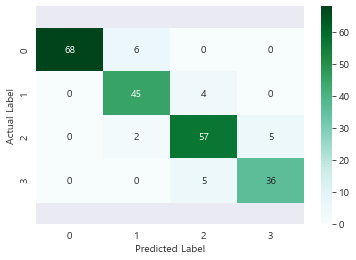

In [61]:
cnf_matrix_model(Predicted_xgb1)

> 3개의 파라미터를 조정했더니 f1_score가 90.4%까지 상승 

### XGB voting

>class_weightdict_'balanced' y 값을 사용하여 입력 데이터의 클래스 빈도에 반비례하여 가중치를 자동으로 조정합니다. 다중 출력의 경우 y의 각 열의 가중치가 곱해집니다.
>sample_weight -> 클래스 가중치는 클래스 불균형을 수정하기 위해 가중치를 변경합니다
>
>sample_weight 사용법은 학습 데이터 세트의 목표 클래스를 균형 잡는 것이 목적이라는 것을 기억하고 sample_weight 간단합니다. 즉, X 가 관측 값이고 y 가 클래스 (레이블) 인 경우 len(X) == len(y) == len(sample_wight)

In [62]:
#target 불균형에 대해 class_weigt 라이브러리 사용
# 클래스 불균형 문제를 해소하기 위해 compute_sample_weight 사용

y_train_weights = class_weight.compute_sample_weight('balanced', target, indices=None)

In [63]:
#파라미터 설정
fit_params={'verbose': False}
fit_params['verbose'] = 50

In [64]:
# 여러가지 모델을 사용해보았지만 XGBoost 제외하고는 성능이 굉장히 떨어지는 모습을 보였음
# 다중 분류기들을 Voting하는 방법을 사용하기 위해 XGBoost 모델의 random_state(난수값)을 변경해가면서 10개의 XGB 분류기를 만들어냄
# 파라미터는 위에서 정의해준 최적 파라미터 사용 

clfs = []
for i in range(10):
    clf = xgb.XGBClassifier(random_state=217+i, n_jobs=4, **best_param1)
    
    clfs.append(('xgb{}'.format(i), clf))

In [65]:
# VotingClassifier 정의 
# 위에서 정의해준 10개의 XGB 분류기를 사용
# 앙상블의 소프트 보팅
vc = VotingClassifier(clfs, voting='soft')
del(clfs)

>voting 서로 다른 ml알고리즘으로 여러 개의 분류기를 생성하고,투표를 통해 최종 예측 결과를 결정하는 방식
>
>하드 보팅 - 분류기 간 닫수결로 최종 분류 값 예측
>
>소프트 보팅 - 분류기들의 분류 확률들을 평균 내어 최종 분류값 예측

In [66]:
# 보팅에 불균형을 해결하기 위해 이용했떤 라이브러리를 sample_weight 파라미터를 통해 이용
# 10개의 XGB 분류기로 이루어진 VotingClassifier로 학습 

_ = vc.fit(dat1, target, sample_weight=y_train_weights)

clf_final = vc.estimators_[0]

In [67]:
# 단일 모델, soft voting, hard voting 3가지 방법에 대한 점수
# Hard Voting 방법이 가장 높은 점수를 보임 

global_score = f1_score(test_target, clf_final.predict(test_x1), average='weighted')
vc.voting = 'hard'
global_score_hard = f1_score(test_target, vc.predict(test_x1), average='weighted')
vc.voting = 'soft'
global_score_soft = f1_score(test_target, vc.predict(test_x1),average='weighted')
print('Validation score of a single XGB Classifier: {:.4f}'.format(global_score))
print('Validation score of a VotingClassifier on 3 XGB with hard voting strategy: {:.4f}'.format(global_score_hard))
print('Validation score of a VotingClassifier on 3 XGB with soft voting strategy: {:.4f}'.format(global_score_soft))

Validation score of a single XGB Classifier: 0.9046
Validation score of a VotingClassifier on 3 XGB with hard voting strategy: 0.9045
Validation score of a VotingClassifier on 3 XGB with soft voting strategy: 0.9045


>average 파라미터 설명 -> weigted 선택
>
>(f1_score(test_target, vc.predict(test_x1), average='weighted')
>
>macro 평균은 클래스별 f1 score에 가중치를 주지 않음 클래스 크기에 상관없이 모든 클래스를 같은 비중으로 다룸
>
>micro 평균은 모든 클래스의 FP,FN,TP의 총 수를 헤아린 다음 precision, recall, f1 score를 수리초 계산한다
>
>weighted 평균은 클래스별 샘플 수로 가중치를 두어 f1 score의 평균을 계산한다. 이 값이 분류 report에 나타나는 값이다(각각의 라벨에 동일한 가중치(target label을 갖는 인스턴스의 수)를 부여)
>
>samples 평균은 각 인스턴스에 대해 f1 score를 계산하는 함수고 다중 레이블 분류에 사용된다(여기선 이용x)

f1  0.9045246073567706
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        74
           1       0.85      0.92      0.88        49
           2       0.86      0.89      0.88        64
           3       0.88      0.88      0.88        41

    accuracy                           0.90       228
   macro avg       0.90      0.90      0.90       228
weighted avg       0.91      0.90      0.90       228



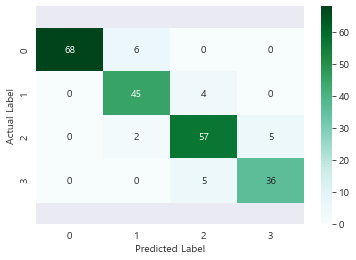

In [68]:
# 최종 모델 점수와 Confusion Matrix 

cnf_matrix = confusion_matrix(test_target, vc.predict(test_x1))
g = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="BuGn", fmt='g')
buttom , top = g.get_ylim()
g.set_ylim(buttom+0.5, top-0.5)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

print('f1 ',f1_score(y_true=test_target, y_pred=vc.predict(test_x1), average='weighted'))
print(classification_report(test_target, vc.predict(test_x1)))

> f1_score 90.4%
>
> a를 a라 잘 예측 68개(소멸위험이 큰 지역 68개)
>
> d를 d라고 잘 예측 36개(소멸위험이 작은 지역 36개)

### e.앙상블 <a id="four-e"></a>

>모델 결합 : 마지막으로, 여러 수준의 모델을 앙상블합니다. 최상의 결과를 얻으려면 모델끼리의 상관 관계 확인

>앙상블 : 여러가지 예측모형들을 만든 후 조합하여 하나의 최종 예측모형을 만드는 방법 
>
>장점 : 성능이 많이 좋아짐. 오버피팅도 방지 됨. 
>
>단점 : 해석력이 많이 떨어짐. 모델이 무거워짐. 

In [72]:
test_XGB = pd.Series(vc.predict(test_x1), name="XGB")
test_GBC = pd.Series(vc2.predict(test_x1), name="GBC")
test_RFC = pd.Series(vc3.predict(test_x1), name="RFC")

ensemble_results = pd.concat([test_XGB,test_GBC,test_RFC],axis=1)

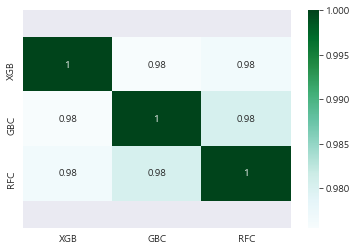

In [73]:
g= sns.heatmap(ensemble_results.corr(),annot=True,cmap='BuGn')
buttom , top = g.get_ylim()
g.set_ylim(buttom+0.5, top-0.5)
plt.show()

>모델끼리의 상관관계 확인결과 xgb와 gbc를 통해서 앙상블을 하기로 결정함

In [74]:
#xgb와 gbc에 각각의 가중치를 주는 함수 만듬
def combine_voters(data, weights=[0.5, 0.5]):
    # do soft voting with both classifiers
    vc.voting="soft"
    vc1_probs = vc.predict_proba(data)
    vc2.voting="soft"
    vc2_probs = vc2.predict_proba(data) 
    
    final_vote = (vc1_probs * weights[0]) + (vc2_probs * weights[1])
    predictions = np.argmax(final_vote, axis=1)
    
    return predictions

In [75]:
#xgb에는 0.8의 가중치를 gbc에는 0.2의 가중치를 줘서 앙상블
combo_preds = combine_voters(test_x1, weights=[0.8, 0.2])
global_combo_score_soft = f1_score(test_target, combo_preds, average='weighted')
global_combo_score_soft

0.913219839582179

> xgb와 rf, xgb와 gbc와 rf, gbc와 rf 모두 앙상블을 했을때보다 xgb와 gbc의 스코어가 높게 나왔다

> 최종 앙상블 모델의 성능은 91.3%

## 결과 <a id="five"></a>

In [76]:
# 등급 매핑 
combo_preds

array([1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 3,
       3, 2, 3, 3, 2, 1, 3, 3, 3, 3, 3, 2, 3, 2, 1, 1, 1, 3, 3, 2, 2, 2,
       2, 3, 1, 3, 3, 3, 0, 0, 3, 0, 1, 1, 0, 3, 0, 2, 0, 2, 1, 0, 1, 0,
       0, 2, 1, 0, 3, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       2, 2, 3, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 2, 1, 2, 2, 3, 3, 1, 3, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 3, 2, 2, 3, 3, 3, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2,
       2, 0, 2, 2, 3, 1, 2, 3, 3, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 1, 0, 2,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       2, 0, 0, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 3, 0, 3, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 2, 2, 3, 1], dtype=int64)

In [77]:
#예측치의 숫자를 다시 문자로 매핑
pred = LB.inverse_transform(combo_preds)
pred

array(['b', 'b', 'b', 'b', 'b', 'b', 'a', 'a', 'c', 'b', 'a', 'b', 'c',
       'a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'd', 'd', 'c', 'd', 'd',
       'c', 'b', 'd', 'd', 'd', 'd', 'd', 'c', 'd', 'c', 'b', 'b', 'b',
       'd', 'd', 'c', 'c', 'c', 'c', 'd', 'b', 'd', 'd', 'd', 'a', 'a',
       'd', 'a', 'b', 'b', 'a', 'd', 'a', 'c', 'a', 'c', 'b', 'a', 'b',
       'a', 'a', 'c', 'b', 'a', 'd', 'a', 'b', 'a', 'a', 'a', 'a', 'b',
       'a', 'a', 'a', 'b', 'b', 'a', 'a', 'a', 'a', 'a', 'c', 'c', 'd',
       'c', 'b', 'c', 'c', 'b', 'c', 'd', 'c', 'c', 'b', 'c', 'b', 'c',
       'c', 'd', 'd', 'b', 'd', 'c', 'c', 'b', 'b', 'b', 'c', 'c', 'c',
       'c', 'b', 'b', 'c', 'b', 'b', 'c', 'd', 'c', 'c', 'd', 'd', 'd',
       'c', 'c', 'c', 'c', 'c', 'd', 'd', 'd', 'd', 'd', 'c', 'd', 'c',
       'c', 'c', 'c', 'c', 'c', 'c', 'd', 'd', 'd', 'd', 'c', 'c', 'a',
       'c', 'c', 'd', 'b', 'c', 'd', 'd', 'a', 'c', 'a', 'a', 'a', 'c',
       'a', 'b', 'a', 'c', 'b', 'a', 'c', 'a', 'b', 'a', 'a', 'a

In [78]:
# 데이터프레임화
result = pd.DataFrame({
    "sigun" :test_x1.index,
    "소멸위험등급":  pred
})
result.head()

,sigun,소멸위험등급
0,강원도강릉시,b
1,강원도고성군,b
2,강원도동해시,b
3,강원도삼척시,b
4,강원도속초시,b


In [79]:
#소멸위험인 시군구
result[result.소멸위험등급 == 'a']

,sigun,소멸위험등급
6,강원도양양군,a
7,강원도영월군,a
10,강원도정선군,a
13,강원도태백시,a
14,강원도평창군,a
...,...,...
217,충청북도괴산군,a
218,충청북도단양군,a
219,충청북도보은군,a
220,충청북도영동군,a


In [80]:
#정성적 분석을 할 때 이용하기 위해 csv형태로 저장
result_a = result[result.소멸위험등급 == 'a']
#result_a.to_csv('소멸위험시군구_최종.csv',encoding='cp949')

> 소멸위험지수가 큰 지방자치단체

In [81]:
result[result.소멸위험등급 == 'd']

,sigun,소멸위험등급
21,경기도광명시,d
22,경기도광주시,d
24,경기도군포시,d
25,경기도김포시,d
28,경기도부천시,d
29,경기도성남시,d
30,경기도수원시,d
31,경기도시흥시,d
32,경기도안산시,d
34,경기도안양시,d


> 소멸위험지수가 작은 지방자치단체